# **PLS  (Partial Least Square)를 이용한 Odor 분석**

---

odo : All Data

odol : Log Transform

---

In [ ]:
import rpy2
%load_ext rpy2.ipython

In [ ]:
%%R
package_version(R.version)

[1] ‘4.0.5’


In [ ]:
%%R

.libPaths("/content/drive/MyDrive/R packages")
.libPaths()

[1] "/content/drive/MyDrive/R packages" "/usr/local/lib/R/site-library"    
[3] "/usr/lib/R/site-library"           "/usr/lib/R/library"               


## **0. Packages Installation**
---

In [ ]:
%%R

# install.packages("corrplot")                  
# install.packages("PerformanceAnalytics")      # 상관분석 시각화
# install.packages("mdatools")                       # pls
# install.packages("caret")         
# install.packages("mice")    # M.I 결측치 대체
# install.packages("stringr")
# install.packages("devtools")
# install.packages("lmtest")      # Durbin-Watson test (잔차의 독립성)
# install.packages("Boruta")

library(Boruta)
library(lmtest)
library(devtools)
library(mice)
library(stringr)
library(corrplot)
library(PerformanceAnalytics)
library(mdatools)
library(caret)

R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: Loading required package: usethis

R[write to console]: 
Attaching package: ‘mice’


R[write to console]: The following object is masked from ‘package:stats’:

    filter


R[write to console]: The following objects are masked from ‘package:base’:

    cbind, rbind


R[write to console]: corrplot 0.84 loaded

R[write to console]: Loading required package: xts

R[write to console]: 
Attaching package: ‘PerformanceAnalytics’


R[write to console]: The following object is masked from ‘package:graphics’:

    legend


R[write to console]: Loading required package: lattice

R[write to console]: Loading required package: ggplot2

R[write to console]: Registered S3 methods overwritten by 'caret':
  method        from    
  predict.plsda mdatools
  print.plsda   mdatoo

**plsVarSel은  R version 4.0.5에서 지원하지 않으므로, Version을 지정해 다운해야된다.**

In [ ]:
%%R
# install_version("plsVarSel", version = "0.9.6", repos = "http://cran.us.r-project.org") # VIP
library(plsVarSel)

R[write to console]: Loading required package: pls

R[write to console]: 
Attaching package: ‘pls’


R[write to console]: The following object is masked from ‘package:caret’:

    R2


R[write to console]: The following object is masked from ‘package:mdatools’:

    crossval


R[write to console]: The following object is masked from ‘package:corrplot’:

    corrplot


R[write to console]: The following object is masked from ‘package:stats’:

    loadings




## **1. Data Preparation** 
---

### **1) Read and Select to variable (odo)** 

In [ ]:
%%R

getwd()
#od <- read.csv("drive/MyDrive/PLS_양돈 농가/s1.csv", fileEncoding = "euc-kr")
#od <- read.csv("drive/MyDrive/PLS_양돈 농가/s2.csv", fileEncoding = "euc-kr")
#od <- read.csv("drive/MyDrive/PLS_양돈 농가/s3.csv", fileEncoding = "euc-kr")
od <- read.csv("drive/MyDrive/PLS_양돈 농가/s4.csv", fileEncoding = "euc-kr")
head(od)

    측정일 complex.odor Ammoina Hydorgen.sulfide Methyl.mercaptan
1 18.08.14         4481    2.77           201.00            17.50
2 18.08.14          448    0.61             2.57             0.07
3 18.08.14         1442    1.25           460.00             4.97
4 18.08.14          448    0.41           397.00             0.07
5 18.08.14          100    0.24             4.13             0.07
6 18.08.21           20    0.27             1.62             0.07
  Dimethyl.sulfide Dimethyl.disulfide Acetic.acid Propionic.acid
1             0.08               0.04      173.00           1.45
2             0.08               2.33        6.48           3.39
3             0.08               0.04        6.94          49.70
4             0.08               0.04        6.94           1.42
5             0.08               0.04        6.94           1.95
6             0.08               0.04        1.81          10.80
  iso.Butryic.aicd Butricy.aicd iso.Valeric.acid Valeric.acid Phenol p.Cresol
1       

In [ ]:
%%R

### 측정일, 농장명 변수 제거 

odo <- subset(od, select = -c(측정일, 농장명))
head(odo)

  complex.odor Ammoina Hydorgen.sulfide Methyl.mercaptan Dimethyl.sulfide
1         4481    2.77           201.00            17.50             0.08
2          448    0.61             2.57             0.07             0.08
3         1442    1.25           460.00             4.97             0.08
4          448    0.41           397.00             0.07             0.08
5          100    0.24             4.13             0.07             0.08
6           20    0.27             1.62             0.07             0.08
  Dimethyl.disulfide Acetic.acid Propionic.acid iso.Butryic.aicd Butricy.aicd
1               0.04      173.00           1.45            20.60         0.98
2               2.33        6.48           3.39             1.07         0.52
3               0.04        6.94          49.70             8.27        31.40
4               0.04        6.94           1.42             8.69        61.20
5               0.04        6.94           1.95             2.29         5.49
6             

### **2) 결측치 확인 및 처리**

#### **a. 결측값을 평균값으로 대체**

In [ ]:
# %%R


# ### 공백을 NA 값 취급
# odo <- replace(odo, odo == "", NA)


# ### 숫자변수가 문자변수로 잘못 입력된 변수를 숫자형으로 변환

# indx <- sapply(odo, is.character)
# odo[indx] <- lapply(odo[indx], function(x) as.numeric(as.character(x)))
# # str(odo)

# ### 결측치 확인

# odo<- replace(odo, odo == "ND", NA)

# if (sum(is.na(odo)) == 0) {
#     cat("결측치 개수 :", sum(is.na(odo)), "개")
# }else{
#     cat("- 평균으로 결측치 대체 - \n 결측치 대체 개수 :", sum(is.na(odo)), "개")
 
#     for(i in 1:ncol(odo)){
#         odo[is.na(odo[,i]),] <- round(mean(odo[,i], na.rm = T),3)
#         }
#     cat("\n ->", sum(is.na(odo)), "개")
# }



#### **b. ND - > 0, 결측 -> M.I**

In [ ]:
%%R

### 공백을 NA 값 취급
odo <- replace(odo, odo == "", NA)


### 결측치 확인
nd <- sum(str_count(odo, "ND"))
na <- sum(is.na(odo))

cat("NA , NA 개수 :", (na+nd), "개 \n \n")


if ((nd + na) == 0) {
    print("결측치 개수 : 0 개")
}else{
    
    # "ND" 먼저 제거 (그래야 ND와 문자열 공백(NA)구분 가능)
    cat("'ND' 개수 :", nd, "개")
    odo <- replace(odo, odo == "ND", 0)
    cat("->", sum(str_count(odo, "ND")), "개 (0으로 대체) \n \n")

    # 문자열을 숫자열로 변환(공백 문자를 NA로 바꾸기 위해서)
    indx <- sapply(odo, is.character)
    odo[indx] <- lapply(odo[indx], function(x) as.numeric(as.character(x)))

    cat("결측치 개수 :", na, "개")
    imp <- mice(odo)      # M.I 사용
    odo <- complete(imp)
    cat("\n ->", sum(is.na(odo)), "개 (M.I로 대체)")
}

NA , NA 개수 : 0 개 
 
[1] "결측치 개수 : 0 개"


### **3) Data visualizations (odo)**



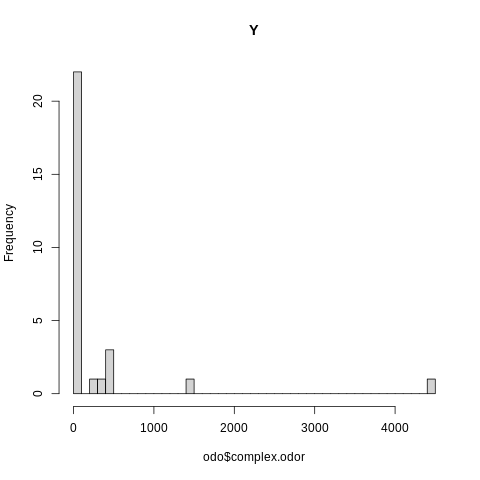

In [ ]:
%%R

### 반응 변수
hist(odo$complex.odor, main = "Y", breaks = 50)

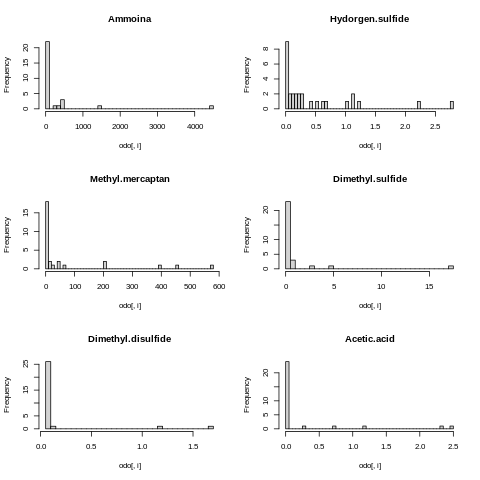

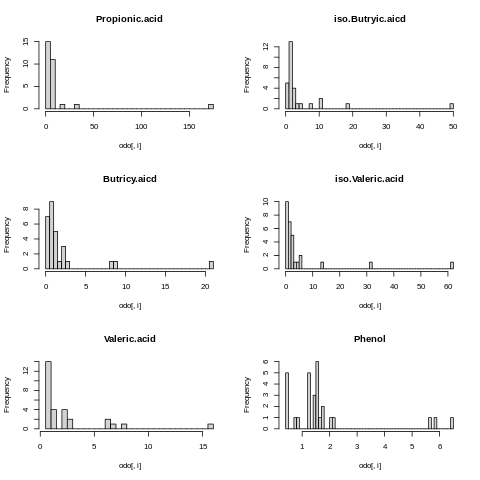

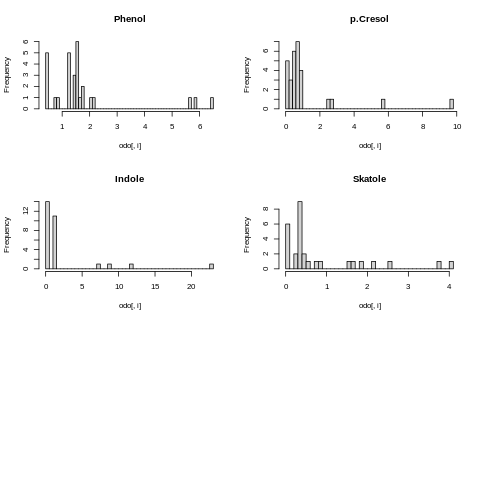

In [ ]:
%%R

### 독립 변수

par(mfrow = c(3,2))
for (i in c(1:6)) {
    hist(odo[,i], type = "b" , main = names(odo)[i+1], breaks = 50)
}

for (i in c(7:12)) {
    hist(odo[,i], type = "b" , main = names(odo)[i+1], breaks = 50)
}

for (i in c(12:15)) {
    hist(odo[,i], type = "b" , main = names(odo)[i+1], breaks = 50)
}

par(mfrow = c(1,1))

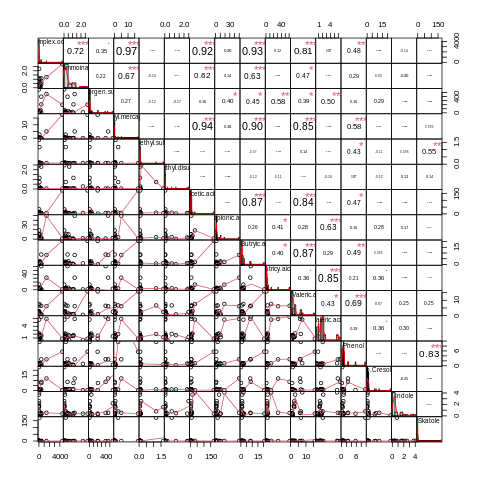

In [ ]:
%%R

# as.data.frame(round(cor(odo),4))

chart.Correlation(odo, histogram = T, pch = 19)

### **4) 정규성 확인 - 잔차 검정**

In [ ]:
%%R

mr <- lm(complex.odor~., data = odo)

summary(mr)


Call:
lm(formula = complex.odor ~ ., data = odo)

Residuals:
     Min       1Q   Median       3Q      Max 
-137.243  -72.670   -0.046   19.228  254.229 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)  
(Intercept)         115.6172   174.9657   0.661   0.5203  
Ammoina              34.0421    63.8135   0.533   0.6027  
Hydorgen.sulfide      0.4383     0.2780   1.577   0.1388  
Methyl.mercaptan    177.2682    59.5663   2.976   0.0107 *
Dimethyl.sulfide      8.0833   114.2126   0.071   0.9447  
Dimethyl.disulfide  106.3500    54.2853   1.959   0.0719 .
Acetic.acid          17.7317    11.5021   1.542   0.1472  
Propionic.acid        8.8669     9.9173   0.894   0.3875  
iso.Butryic.aicd     43.1910    67.3846   0.641   0.5327  
Butricy.aicd         12.4523    16.3183   0.763   0.4590  
iso.Valeric.acid    -79.0727   100.8050  -0.784   0.4469  
Valeric.acid         20.4104   103.7069   0.197   0.8470  
Phenol             -290.7246   299.0586  -0.972   0.3487  
p.Cre

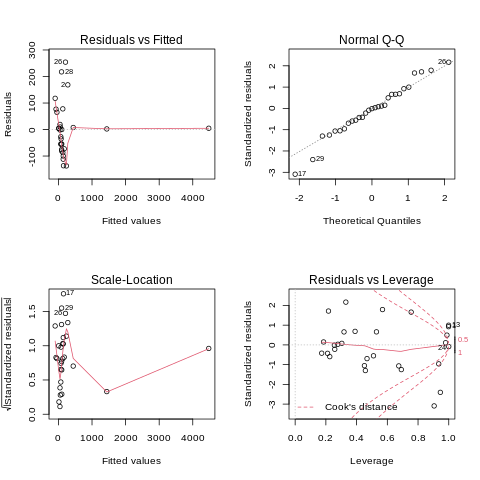

In [ ]:
%%R

par(mfrow=c(2,2))
plot(mr)
par(mfrow=c(1,1))

##### **a. 잔차의 독립성 (Durbin-Watson test)**

- $H_0$ : 잔차는 독립이다.  vs  $H_1$ : 자차가 자기상관관계가 있다.

-  DW statistic 값이 2 근처의 값이 나오는 경우 자기상관관계가 없다. (= 독립)

In [ ]:
%%R

dwtest(mr)


	Durbin-Watson test

data:  mr
DW = 2.921, p-value = 0.9574
alternative hypothesis: true autocorrelation is greater than 0



##### **b. 잔차의 정규성 (Shapiro-test)**

- $H_0$ : 모집단은 정규분포를 따른다.   vs   $H_1$ : 모집단은 정규분포를 따르지 않는다.

In [ ]:
%%R

mr_res <- residuals(mr)
shapiro.test(mr_res)


	Shapiro-Wilk normality test

data:  mr_res
W = 0.91979, p-value = 0.03012



### **5) Log 정규성 확인 - 잔차 검정**

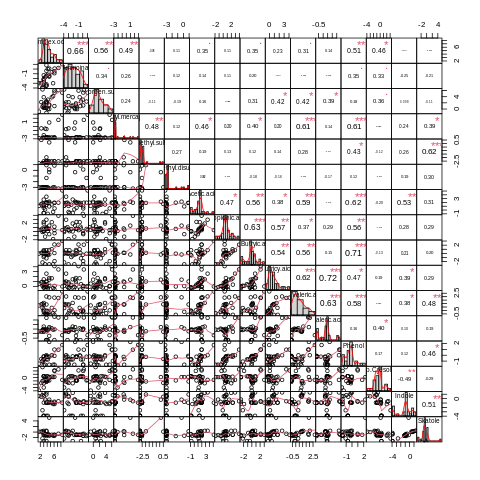

In [ ]:
%%R 
odol <- log(odo)
chart.Correlation(odol, histogram = T, pch = 19)

In [ ]:
%%R

mrl <- lm(complex.odor~., data = odol)

summary(mrl)


Call:
lm(formula = complex.odor ~ ., data = odol)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3231 -0.3261  0.0012  0.3883  1.7805 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         4.77878    1.10367   4.330 0.000817 ***
Ammoina             0.31284    0.20416   1.532 0.149408    
Hydorgen.sulfide    0.15838    0.15211   1.041 0.316743    
Methyl.mercaptan    0.27786    0.23000   1.208 0.248543    
Dimethyl.sulfide   -0.44863    0.38291  -1.172 0.262372    
Dimethyl.disulfide  0.09650    0.19444   0.496 0.627992    
Acetic.acid         0.28568    0.45147   0.633 0.537857    
Propionic.acid     -0.39818    0.29037  -1.371 0.193498    
iso.Butryic.aicd    0.39066    0.41345   0.945 0.361955    
Butricy.aicd       -0.31164    0.48938  -0.637 0.535303    
iso.Valeric.acid   -0.63547    0.87185  -0.729 0.479006    
Valeric.acid        0.62316    1.15606   0.539 0.598975    
Phenol              0.35456    0.65208   0.544 0.595822    


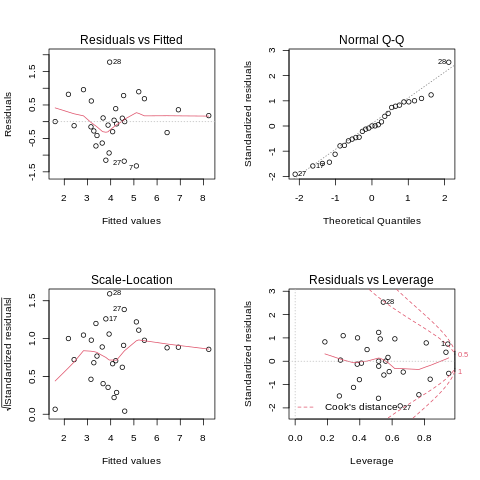

In [ ]:
%%R

par(mfrow=c(2,2))
plot(mrl)
par(mfrow=c(1,1))

##### **a. 잔차의 독립성 (Durbin-Watson test)**

- $H_0$ : 잔차는 독립이다.  vs  $H_1$ : 자차가 자기상관관계가 있다.

-  DW statistic 값이 2 근처의 값이 나오는 경우 자기상관관계가 없다. (= 독립)

In [ ]:
%%R

dwtest(mrl)


	Durbin-Watson test

data:  mrl
DW = 2.4692, p-value = 0.6693
alternative hypothesis: true autocorrelation is greater than 0



##### **b. 잔차의 정규성 (Shapiro-test)**

- $H_0$ : 모집단은 정규분포를 따른다.   vs   $H_1$ : 모집단은 정규분포를 따르지 않는다.

In [ ]:
%%R

mrl_res <- residuals(mrl)
shapiro.test(mrl_res)


	Shapiro-Wilk normality test

data:  mrl_res
W = 0.97704, p-value = 0.7586



### **6) Log변환 + 변수 선택(Boruta)**

In [ ]:
%%R

bo <- Boruta(complex.odor ~ ., data = odol, doTrace = 0)
# names(bo)   # Boruta가 포함하는 결과들의 이름 

In [ ]:
%%R

# 중요한 변수
bs <- getSelectedAttributes(bo, withTentative = TRUE)
bs

[1] "Ammoina"          "Hydorgen.sulfide" "Methyl.mercaptan" "iso.Butryic.aicd"
[5] "iso.Valeric.acid" "Phenol"           "p.Cresol"         "Indole"          
[9] "Skatole"         


In [ ]:
%%R

# 중요 변수 조정
roughFixMod <- TentativeRoughFix(bo)

bs2 <- getSelectedAttributes(roughFixMod)
bs2

[1] "Ammoina"          "Hydorgen.sulfide" "iso.Butryic.aicd" "Phenol"          
[5] "Indole"          


In [ ]:
%%R

# 변수 중요도
imps <- attStats(roughFixMod)
str(imps)

'data.frame':	15 obs. of  6 variables:
 $ meanImp  : num  7.85 5.29 2.86 1.25 1.71 ...
 $ medianImp: num  7.84 5.26 2.82 1.3 1.76 ...
 $ minImp   : num  6.1952 3.4798 1.0335 -1.0569 0.0389 ...
 $ maxImp   : num  9.65 7.03 4.55 3.32 3.58 ...
 $ normHits : num  0.9697 0.8687 0.5253 0.0303 0.101 ...
 $ decision : Factor w/ 3 levels "Tentative","Confirmed",..: 2 2 3 3 3 3 3 2 3 3 ...


In [ ]:
%%R

imps2 <- imps[imps$decision != "Rejected", c("meanImp","decision")]
imps2[order(-imps2$meanImp), ]

                  meanImp  decision
Ammoina          7.847543 Confirmed
Phenol           6.598594 Confirmed
iso.Butryic.aicd 5.340056 Confirmed
Hydorgen.sulfide 5.291587 Confirmed
Indole           3.932593 Confirmed


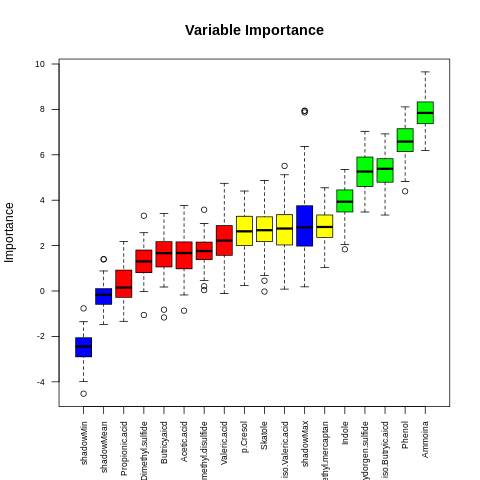

In [ ]:
%%R

plot(bo, cex.axis = .7, las = 2, xlab = "", main = "Variable Importance")

In [ ]:
%%R

odolc <- cbind(odol$complex.odor, odol[,rownames(imps2)])
names(odolc)[names(odolc) == "odol$complex.odor"] <- "complex.odor"
head(odolc)

  complex.odor    Ammoina Hydorgen.sulfide iso.Butryic.aicd     Phenol
1     8.407602  1.0188473        5.3033049       3.02529108  1.7387102
2     6.104793 -0.4942963        0.9439059       0.06765865 -0.1053605
3     7.273786  0.2231436        6.1312265       2.11263451  0.9477894
4     6.104793 -0.8915981        5.9839363       2.16217294  0.9669838
5     4.605170 -1.4271164        1.4182774       0.82855182 -0.2484614
6     2.995732 -1.3093333        0.4824261       0.55961579 -0.2484614
      Indole
1 -0.9162907
2 -0.9162907
3 -0.5978370
4 -0.6931472
5 -0.9162907
6 -0.9162907


## **2. PLS**
---

### **1) Model 생성 (pr, prl, prlc)**

In [ ]:
%%R

X <- subset(odo, select = -c(complex.odor))
y <- odo[, "complex.odor"]

Xl <- subset(odol, select = -c(complex.odor))
yl <- odol[, "complex.odor"]

Xlc <- subset(odolc, select = -c(complex.odor))
ylc <- odolc[, "complex.odor"]

[1] 29


In [ ]:
%%R

# 15개의 잠재 변수 생성 / Validation method : Leave-One-Out

pr <- pls(X, y, ncomp = ncol(X), scale = F, cv = length(y))      # All data 
prl <- pls(Xl, yl, ncomp = ncol(Xl), scale = F, cv = length(yl))    # All data + Log
prlc <- pls(Xlc, ylc, ncomp = ncol(Xlc), scale = F, cv = length(ylc))    # All data + Log + Select

, , y1

                      Comp 1       Comp 2    Comp 3    Comp 4    Comp 5
Ammoina            0.3866359 2.892867e-04 0.2159752 0.5784669 0.6593564
Hydorgen.sulfide   0.2738091 4.963080e-01 0.8005860 0.8350159 0.8051677
Methyl.mercaptan   0.4087463 2.888586e-02 0.2381354 0.4481771 0.6249362
Dimethyl.sulfide   0.4315238 5.590758e-01 0.4594815 0.7634530 0.7292986
Dimethyl.disulfide 0.5741458 9.549921e-01 0.4270328 0.7616723 0.7025858
Acetic.acid        0.4447222 3.317954e-01 0.3453079 0.4888366 0.5462378
Propionic.acid     0.4923366 9.445291e-01 0.6192080 0.7962682 0.7834550
iso.Butryic.aicd   0.3916257 9.371939e-03 0.2712154 0.4519287 0.6443724
Butricy.aicd       0.3130406 9.400038e-01 0.8999819 0.9579546 0.7981006
iso.Valeric.acid   0.4025267 1.197814e-01 0.5215756 0.9030887 0.8078714
Valeric.acid       0.6971907 9.383186e-01 0.9300600 0.9119814 0.7294751
Phenol             0.3928787 6.718730e-06 0.2992788 0.3880307 0.6171252
p.Cresol           0.6314504 9.968150e-01 0.4138188 0.57

In [ ]:
%%R
pr

[1] 29


### **2) 최적의 ncomp 결정**

All data ncomp :  2 
All data + Log ncomp :  1 
All data + Log + Cor ncomp :  1

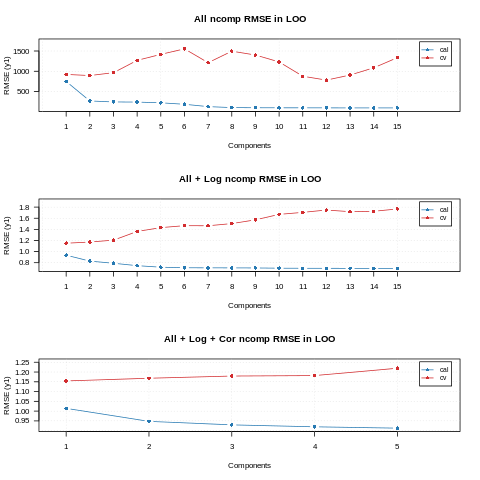

In [ ]:
%%R

par(mfrow = c(3,1))
plotRMSE(pr, legendpos = "topright", main = "All ncomp RMSE in LOO")
plotRMSE(prl, legendpos = "topright", main = "All + Log ncomp RMSE in LOO")
plotRMSE(prlc, legendpos = "topright", main = "All + Log + Cor ncomp RMSE in LOO")
par(mfrow = c(1,1))

# 최적의 ncomp 수 
ocom = pr$ncomp.selected
ocoml = prl$ncomp.selected
ocomlc = prlc$ncomp.selected


cat("All data ncomp : ", ocom, "\n")
cat("All data + Log ncomp : ", ocoml, "\n")
cat("All data + Log + Cor ncomp : ", ocomlc)

### **3) Validation and Prediction**

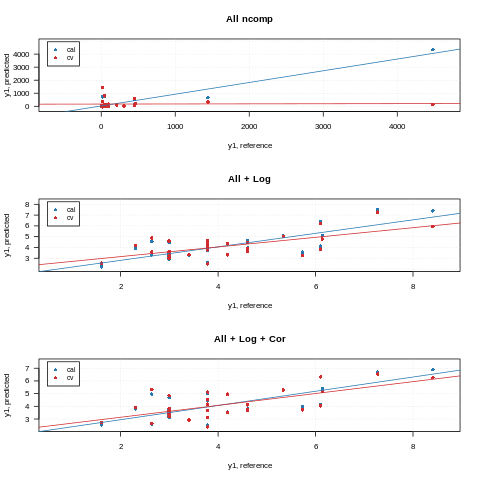

In [ ]:
%%R

par(mfrow=c(3,1))
plotPredictions(pr, ncomp = ocom, asp = 1, line = T, main = "All ncomp")
plotPredictions(prl, ncomp = ocoml, asp = 1, line = T, main = "All + Log")
plotPredictions(prlc, ncomp = ocomlc, asp = 1, line = T, main = "All + Log + Cor")
par(mfrow=c(1,1))

In [ ]:
%%R
pr$res$cal$y.pred[, ocom, ]

          1           2           3           4           5           6 
4332.163769  100.366685  668.000288  538.353370  111.332244   -4.772964 
          7           8           9          10          11          12 
 120.194117  107.414724  103.783094  112.314830  108.005637  743.304487 
         13          14          15          16          17          18 
  72.864577  109.375951   14.459126   26.782502  730.181476  365.838591 
         19          20          21          22          23          24 
  43.291289   46.717448  -23.257793  -41.621885  -39.811553  107.328603 
         25          26          27          28          29 
   5.677323  211.654563  -28.635200   31.306954   17.387748 


In [ ]:
%%R

y <- odo$complex.odor
y2 <- odol$complex.odor

valid <- round(pr$res$cv$y.pred[, ocom, ], 3) ; fitted <- round(pr$res$cal$y.pred[, ocom, ], 3)
diff_value <- cbind(y, valid, fitted)

valid2 <- round(prl$res$cv$y.pred[, ocoml, ], 3) ; fitted2 <- round(prl$res$cal$y.pred[, ocoml, ], 3)
diff_value2 <- cbind(y2, valid2, fitted2)

valid3 <- round(prlc$res$cv$y.pred[, ocomlc, ], 3) ; fitted3 <- round(prlc$res$cal$y.pred[, ocomlc, ], 3)
diff_value3 <- cbind(y2, valid3, fitted3)


head(diff_value) 
head(diff_value2)
head(diff_value3)


        y2 valid3 fitted3
1 8.407602  6.256   6.885
2 6.104793  4.042   4.155
3 7.273786  6.547   6.694
4 6.104793  6.315   6.317
5 4.605170  4.115   4.137
6 2.995732  3.850   3.796


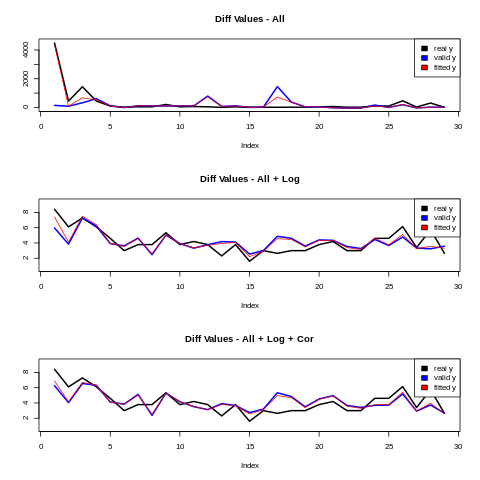

In [ ]:
%%R

par(mfrow = c(3,1))
plot(y, type = "l", ylab="", main = "Diff Values - All", lwd = 2, ylim = c(min(y)-100, max(y)+100))
lines(valid, col = "blue", lwd = 2)
lines(fitted, col = "red", lwd = 1)
legend("topright", c("real y","valid y","fitted y"), fill = c("black","blue","red"))

plot(y2, type = "l", ylab="", main = "Diff Values - All + Log", lwd = 2, ylim = c(min(y2)-1, max(y2)+1))
lines(valid2, col = "blue", lwd = 2)
lines(fitted2, col = "red", lwd = 1)
legend("topright", c("real y","valid y","fitted y"), fill = c("black","blue","red"))

plot(y2, type = "l", ylab="", main = "Diff Values - All + Log + Cor", lwd = 2, ylim = c(min(y2)-1, max(y2)+1))
lines(valid3, col = "blue", lwd = 2)
lines(fitted3, col = "red", lwd = 1)
legend("topright", c("real y","valid y","fitted y"), fill = c("black","blue","red"))

par(mfrow = c(1,1))

### **4) R-Squared**

#### **(1) validation**

In [ ]:
%%R

cat("R2 - All : ", round(pr$res$cv$r2, 4)[1, ocom], "\n")
cat("R2 - All + Log : ", round(prl$res$cv$r2, 4)[1, ocoml], "\n")
cat("R2 - All + Log + Cor : ", round(prlc$res$cv$r2, 4)[1, ocomlc])

R2 - All :  -0.1388 
R2 - All + Log :  0.4339 
R2 - All + Log + Cor :  0.4302

#### **(2) fitted value**

In [ ]:
%%R

cat("R2 - All : ", round(pr$res$cal$r2, 4)[1, ocom], "\n")
cat("R2 - All + Log : ", round(prl$res$cal$r2, 4)[1, ocoml], "\n")
cat("R2 - All + Log + Cor : ", round(prlc$res$cal$r2, 4)[1, ocomlc])

R2 - All :  0.898 
R2 - All + Log :  0.626 
R2 - All + Log + Cor :  0.5603

### **5) Plots**

#### **(1) VIP**

- Variable Important in Project

- VIP ≥ 1 : 의미있는 변수

In [ ]:
%%R

vip <- vipscores(pr, ncomp = ocom)
vip2 <- vipscores(prl, ncomp = ocoml)
vip3 <- vipscores(prlc, ncomp = ocomlc)

print("VIP - All")
print(sort(vip, decreasing = T))

print("VIP - ALL + Log")
print(sort(vip2, decreasing = T))

print("VIP - ALL + Log + Cor")
print(sort(vip3, decreasing = T))

[1] "VIP - All"
 [1] 3.466042784 1.599474691 0.404178878 0.371787952 0.282727454 0.137536291
 [7] 0.104793536 0.086666306 0.069980070 0.055093102 0.022771169 0.021046662
[13] 0.019972929 0.001557857 0.001487468
[1] "VIP - ALL + Log"
 [1] 2.22454323 1.85055891 1.38155694 1.28360604 0.90523318 0.90518675
 [7] 0.83014463 0.56608670 0.48710354 0.25550974 0.24737427 0.18055867
[13] 0.13178709 0.08903994 0.02107660
[1] "VIP - ALL + Log + Cor"
[1] 1.57201406 1.30773122 0.63969954 0.63966673 0.01489417


In [ ]:
%%R

cat("중요한 변수 - All : ",  rownames(vip)[which(vip >= 1)], "(", sum(vip >= 1),"개", ")", "\n")
cat("중요한 변수 - All + Log : ",  rownames(vip2)[which(vip2 >= 1)], "(", sum(vip2 >= 1),"개", ")")
cat("중요한 변수 - All + Log + Cor : ",  rownames(vip3)[which(vip3 >= 1)], "(", sum(vip3 >= 1),"개", ")")

중요한 변수 - All :  Hydorgen.sulfide Acetic.acid ( 2 개 ) 
중요한 변수 - All + Log :  Ammoina Hydorgen.sulfide Methyl.mercaptan p.Cresol ( 4 개 )중요한 변수 - All + Log + Cor :  Ammoina Hydorgen.sulfide ( 2 개 )

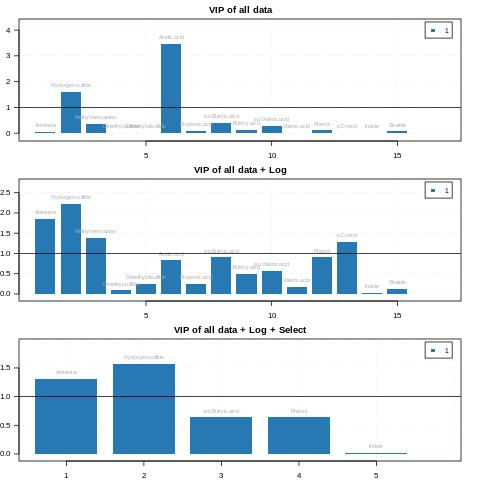

In [ ]:
%%R

par(mfrow = c(3,1), mar = c(2,2,2,2))   # mar : plot inner margin

# VIP of all data
plotVIPScores(pr, ncomp = ocom, type = "h", show.labels = T, main = "VIP of all data")
abline(h = 1)

# VIP of all data + Log
plotVIPScores(prl, ncomp = ocoml, type = "h", show.labels = T, main = "VIP of all data + Log")
abline(h = 1)


# VIP of all data + Log + Cor
plotVIPScores(prlc, ncomp = ocomlc, type = "h", show.labels = T, main = "VIP of all data + Log + Select")
abline(h = 1)

par(mfrow = c(1,1))

#### **(2) loaing plot**

- loading value　=　p　=　[ $(T^T T)^{-1}T^TX$ ]'

-  $X_i = T_i p_i^T + E_i$

- 1 x p vector 

- 어떤 변수의 loading value가 크다 = 그 변수가 해당 잠재변수 생성에 많은 정보가 사용됐다.

##### **- X Loadings**

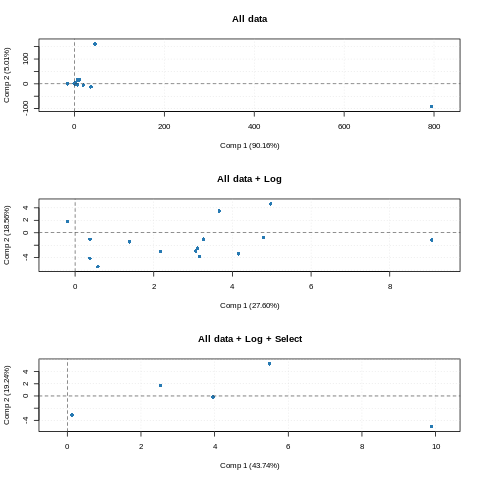

In [ ]:
%%R

par(mfrow = c(3,1))

plotXLoadings(pr, comp = 1:2, main = "All data")
plotXLoadings(prl, comp = 1:2, main = "All data + Log")
plotXLoadings(prlc, comp = 1:2, main = "All data + Log + Select")

par(mfrow = c(1,1))

##### **- XY Loadings**

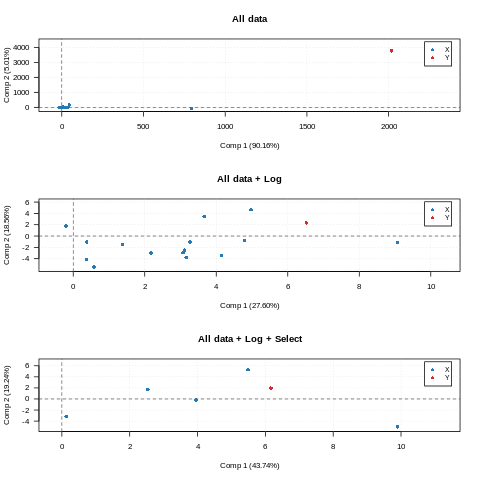

In [ ]:
%%R

par(mfrow = c(3,1))

plotXYLoadings(pr, comp = 1:2, main = "All data")
plotXYLoadings(prl, comp = 1:2, main = "All data + Log")
plotXYLoadings(prlc, comp = 1:2, main = "All data + Log + Select")

par(mfrow = c(1,1))

#### **(3) Score plot**

- Score value　=　T　= 　XW

- Latent Variable

##### **- X scores**

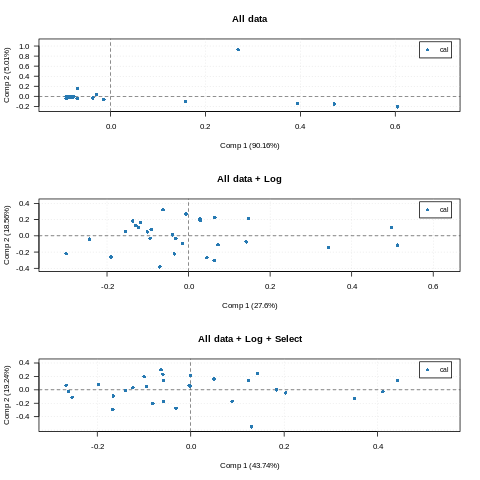

In [ ]:
%%R

par(mfrow = c(3,1))

plotXScores(pr, comp = 1:2, main = "All data")
plotXScores(prl, comp = 1:2, main = "All data + Log")
plotXScores(prlc, comp = 1:2, main = "All data + Log + Select")

par(mfrow = c(1,1))

##### **- XY scores**

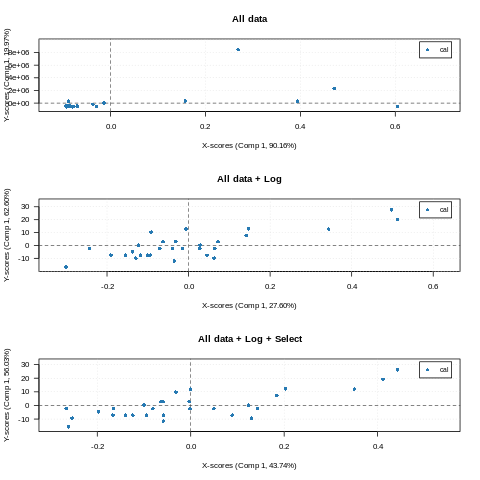

In [ ]:
%%R

par(mfrow = c(3,1))

plotXYScores(pr, comp = 1:2, main = "All data")
plotXYScores(prl, comp = 1:2, main = "All data + Log")
plotXYScores(prlc, comp = 1:2, main = "All data + Log + Select")

par(mfrow = c(1,1))

#### **(4) Corr plot (X)**

In [ ]:
# %%R

# par(mfrow = c(3,1))

# plotCorr(pr)#, ncomp = 1:2, main = "All data")
# # plotCorr(prl, ncomp = 1:2, main = "All data + Log")
# # plotCorr(prlc, ncomp = 1:2, main = "All data + Log + Select")

# par(mfrow = c(1,1))

R[write to console]: Error in UseMethod("plotCorr") : 
  no applicable method for 'plotCorr' applied to an object of class "c('pls', 'regmodel')"




Error in UseMethod("plotCorr") : 
  no applicable method for 'plotCorr' applied to an object of class "c('pls', 'regmodel')"


#### **(5) Regression coefficients**

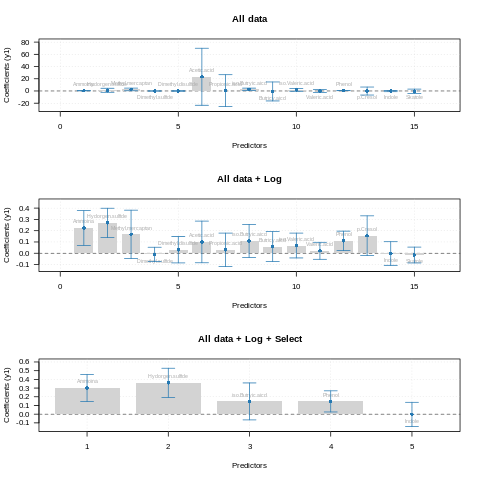

In [ ]:
%%R

par(mfrow = c(3,1))

plotRegcoeffs(pr, show.ci = T, show.labels = T, main = "All data")
plotRegcoeffs(prl, show.ci = T, show.labels = T, main = "All data + Log")
plotRegcoeffs(prlc, show.ci = T, show.labels = T, main = "All data + Log + Select")

par(mfrow = c(1,1))

*** Plots**